In [ ]:
!pip install -q torchinfo torchmetrics torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.6 MB/s eta 0:00:00


In [ ]:
import torch

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchinfo import summary

In [ ]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights, EfficientNet_V2_M_Weights, efficientnet_v2_m
model = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)

In [ ]:
models.EfficientNet_V2_M_Weights.DEFAULT

EfficientNet_V2_M_Weights.IMAGENET1K_V1

In [ ]:
summary(model, input_size=(1, 3, 224, 224), depth=2)

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 1000]                 --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 24, 112, 112]         696
│    └─Sequential: 2-2                                  [1, 24, 112, 112]         15,696
│    └─Sequential: 2-3                                  [1, 48, 56, 56]           396,192
│    └─Sequential: 2-4                                  [1, 80, 28, 28]           1,126,048
│    └─Sequential: 2-5                                  [1, 160, 14, 14]          1,686,340
│    └─Sequential: 2-6                                  [1, 176, 14, 14]          6,650,852
│    └─Sequential: 2-7                                  [1, 304, 7, 7]            24,627,064
│    └─Sequential: 2-8                                  [1, 512, 7, 7]            17,697,548
│    └─Conv2d

In [ ]:
text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import DistilBertModel, DistilBertTokenizer
from torchvision import models, transforms

In [ ]:
class MultimodalGarbageClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # Image encoder (efficientnet_v2_s)
    self.image_encoder = models.efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
    # Remove the final classification layer
    self.image_encoder.classifier = nn.Identity()
    self.image_features_dim = 1280 # no. of dimensions in layer before classifier (last feature classifier)

    # Text encoder (DistilBERT)
    self.text_encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')
    self.text_features_dim = 768

    # number of classes
    self.num_classes = 4

    # Freeze pretrained models initially
    for param in self.image_encoder.parameters():
        param.requires_grad = True

    for param in self.text_encoder.parameters():
        param.requires_grad = True


    # Feature projection layers (to align dimensions between modalities)
    self.image_projection = nn.Linear(self.image_features_dim, 512)
    self.text_projection = nn.Linear(self.text_features_dim, 512)

    # Normalize layers
    self.image_norm = nn.LayerNorm(512)
    self.text_norm = nn.LayerNorm(512)

    self.fusion_dim = 512 * 2

    # Classification head
    self.classifier = nn.Sequential(
        nn.Linear(self.fusion_dim, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, self.num_classes)
    )


  def forward(self, images, input_ids, attention_mask):
    # Process images
    image_features = self.image_encoder(images)
    image_features = image_features.view(image_features.size(0), -1)  # Flatten
    image_features = self.image_projection(image_features)  # [batch_size, 512]
    image_features = self.image_norm(image_features)  # Apply normalization

    # Process text
    text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
    text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token
    text_features = self.text_projection(text_features)  # [batch_size, 512]
    text_features = self.text_norm(text_features)  # Apply normalization

    # Fuse image and text features
    fused_features = torch.cat((image_features, text_features), dim=1)

    # Pass through classification head
    logits = self.classifier(fused_features)

    return logits

In [32]:
model = MultimodalGarbageClassifier()

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
import os
import pathlib

class MultimodalGarbageDataset(Dataset):
    def __init__(self, image_root, transform=None, tokenizer=None, max_length=64):
        # Image dataset using ImageFolder
        self.image_dataset = datasets.ImageFolder(root=image_root, transform=transform)

        # Text processing
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.image_dataset)

    def extract_caption(self, image_path):
        # Get filename stem without extension
        stem = pathlib.Path(image_path).stem

        # Replace underscores with spaces
        text = stem.replace('_', ' ')

        # Remove the last _*int pattern
        last_underscore_pos = text.rfind(' ')  # Space because we already replaced _ with spaces
        if last_underscore_pos != -1:
            text = text[:last_underscore_pos]

        return text

    def __getitem__(self, idx):
        # Get image and label
        image, label = self.image_dataset[idx]

        # Get image path
        image_path = self.image_dataset.imgs[idx][0]

        # Extract caption from filename
        caption = self.extract_caption(image_path)

        # Tokenize caption
        tokens = self.tokenizer.encode_plus(
            caption,
            truncation=True,
            max_length=self.max_length,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )


        return {
            'label': torch.tensor(label, dtype=torch.long),
            'caption' : caption,
            'image': image,
            'input_ids': tokens['input_ids'].flatten(),
            'attention_mask': tokens['attention_mask'].flatten(),
        }

In [ ]:
import random
from PIL import Image
from pathlib import Path

data_path = Path('/content/garbage_data')
train_data_path = Path('/content/drive/MyDrive/ENEL645//garbage_data/CVPR_2024_dataset_Train')
val_data_path = Path('/content/drive/MyDrive/ENEL645/garbage_data/CVPR_2024_dataset_Val')

# Set seed
random.seed(42)
image_path_list = list(train_data_path.glob("*/*.png"))
len(image_path_list)

11629

In [ ]:
weights = models.EfficientNet_V2_M_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
transform = weights.transforms()
transform

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dataset = MultimodalGarbageDataset(
    image_root=train_data_path,
    transform=transform,
    tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
    max_length=64
)

val_dataset = MultimodalGarbageDataset(
    image_root=val_data_path,
    transform=transform,
    tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
    max_length=64
)


In [ ]:
import random

img = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
# Rearrange the order of dimensions
img_permute = img['image'].permute(1, 2, 0)
img['attention_mask']

tensor([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
import matplotlib.pyplot as plt

# Plot the image
# plt.figure(figsize=(10, 7))
# plt.imshow(img['image'].permute(1, 2, 0))
# plt.axis("off")
# plt.title(f"{img['caption']} : {img['label']}" , fontsize=14);

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=16, # how many samples per batch?
                              num_workers=10, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset,
                             batch_size=16,
                             num_workers=10,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a399d675750>,
 <torch.utils.data.dataloader.DataLoader at 0x7a39a5777490>)

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm


def train_model(train_dataloader, val_dataloader, epochs=4):
    model = MultimodalGarbageClassifier()
    model.to(device)

    # Unfreeze last blocks of the pretrained models for fine-tuning
    for name, param in model.image_encoder.named_parameters():
        if "features.6" in name or "features.7" in name or "norm" in name:
            param.requires_grad = True

    # For DistilBERT, unfreeze last 2 layers
    for param in model.text_encoder.transformer.layer[-2:].parameters():
        param.requires_grad = True

    # Setup optimizer and loss function
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=2e-5,
    )
    loss_fn = nn.CrossEntropyLoss()

    best_val_acc = 0.0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0



        for batch in tqdm(train_dataloader):
            # Send data to target device
            labels = batch['label'].to(device)
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)


            optimizer.zero_grad()

            # Forward pass
            y_pred = model(images, input_ids, attention_mask)

            # Calculate loss (per batch)
            loss = loss_fn(y_pred, labels)

            # Backward pass
            loss.backward() # gradient descent
            optimizer.step() # back prop

            # accumulatively add up the loss per epoch
            train_loss += loss.item()
            _, predicted = y_pred.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100.0 * correct / total
        train_loss = train_loss / len(train_dataloader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.inference_mode():
            for batch in tqdm(val_dataloader):
                labels = batch['label'].to(device)
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)

                test_pred = model(images, input_ids, attention_mask)
                loss = loss_fn(test_pred, labels)

                val_loss += loss.item()
                _, predicted = test_pred.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_acc = 100.0 * val_correct / val_total
        val_loss = val_loss / len(val_dataloader)

        # Update learning rate
        # scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_multimodal_garbage_classifier.pth")
            print(f"Model saved with validation accuracy: {val_acc:.3f}%")

    return model

In [ ]:
train_model(train_dataloader, val_dataloader, epochs=4)

  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 1/4 - Train Loss: 0.5079, Train Acc: 81.43% - Val Loss: 0.3118, Val Acc: 89.00%
Model saved with validation accuracy: 89.000%


  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 2/4 - Train Loss: 0.2534, Train Acc: 91.20% - Val Loss: 0.3108, Val Acc: 89.78%
Model saved with validation accuracy: 89.778%


  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 3/4 - Train Loss: 0.1595, Train Acc: 94.57% - Val Loss: 0.3219, Val Acc: 89.44%


  0%|          | 0/727 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

Epoch 4/4 - Train Loss: 0.0952, Train Acc: 96.91% - Val Loss: 0.3337, Val Acc: 90.00%
Model saved with validation accuracy: 90.000%


MultimodalGarbageClassifier(
  (image_encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         

### Load Model & Evaluate it on test data

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration - update these values
model_path = 'best_multimodal_garbage_classifier.pth'
data_dir = '/content/drive/MyDrive/ENEL645/CVPR_2024_dataset_Test'
batch_size = 32
num_classes = 4

In [ ]:
# Create dataset and data loader
# Create dataset
test_dataset = MultimodalGarbageDataset(
    image_root=data_dir,
    transform=transform,
    tokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
    max_length=64
)

# Create dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=12
)

In [ ]:
model = MultimodalGarbageClassifier()

model.load_state_dict(torch.load("/content/best_multimodal_garbage_classifier.pth"))

model = model.to(device)

<ipython-input-27-ab2e2103f2a1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/best_multimodal_garbage_classifier.pth"))


In [ ]:
# Evaluation loop
all_labels = []
all_predictions = []
all_captions = []  # Store captions for later analysis if needed

# load model weights for auto transform
weights = models.EfficientNet_V2_S_Weights.DEFAULT
transform = weights.transforms()
transform

model.eval()
torch.set_grad_enabled(False)
with torch.inference_mode():
    for batch in tqdm(test_loader):
        # Move relevant data to device
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Store captions for reference
        all_captions.extend(batch['caption'])

        # Forward pass - adjust based on your model's expected inputs
        outputs = model(
            images=images,
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Get predictions
        _, predictions = torch.max(outputs, dim=1)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

  0%|          | 0/108 [00:00<?, ?it/s]

### Visualize results in a confusion metrics, and compute:
- Accuracy (weighted and macro)
- Precision
- Recall
- F1 Score

Accuracy: 0.8671

Classification Report:
              precision    recall  f1-score   support

       Black       0.81      0.75      0.78       695
        Blue       0.85      0.92      0.88      1086
       Green       0.92      0.94      0.93       799
         TTR       0.89      0.83      0.86       852

    accuracy                           0.87      3432
   macro avg       0.87      0.86      0.86      3432
weighted avg       0.87      0.87      0.87      3432



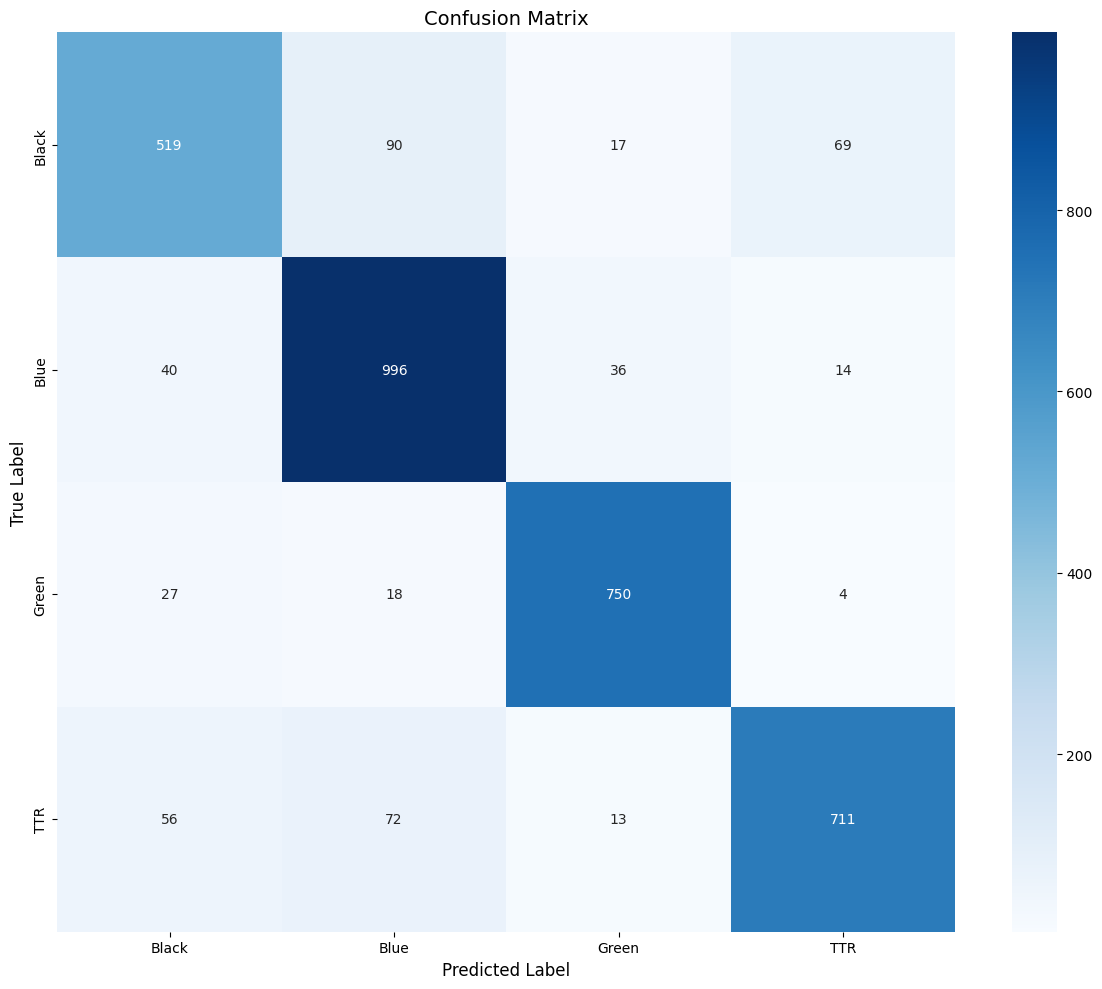

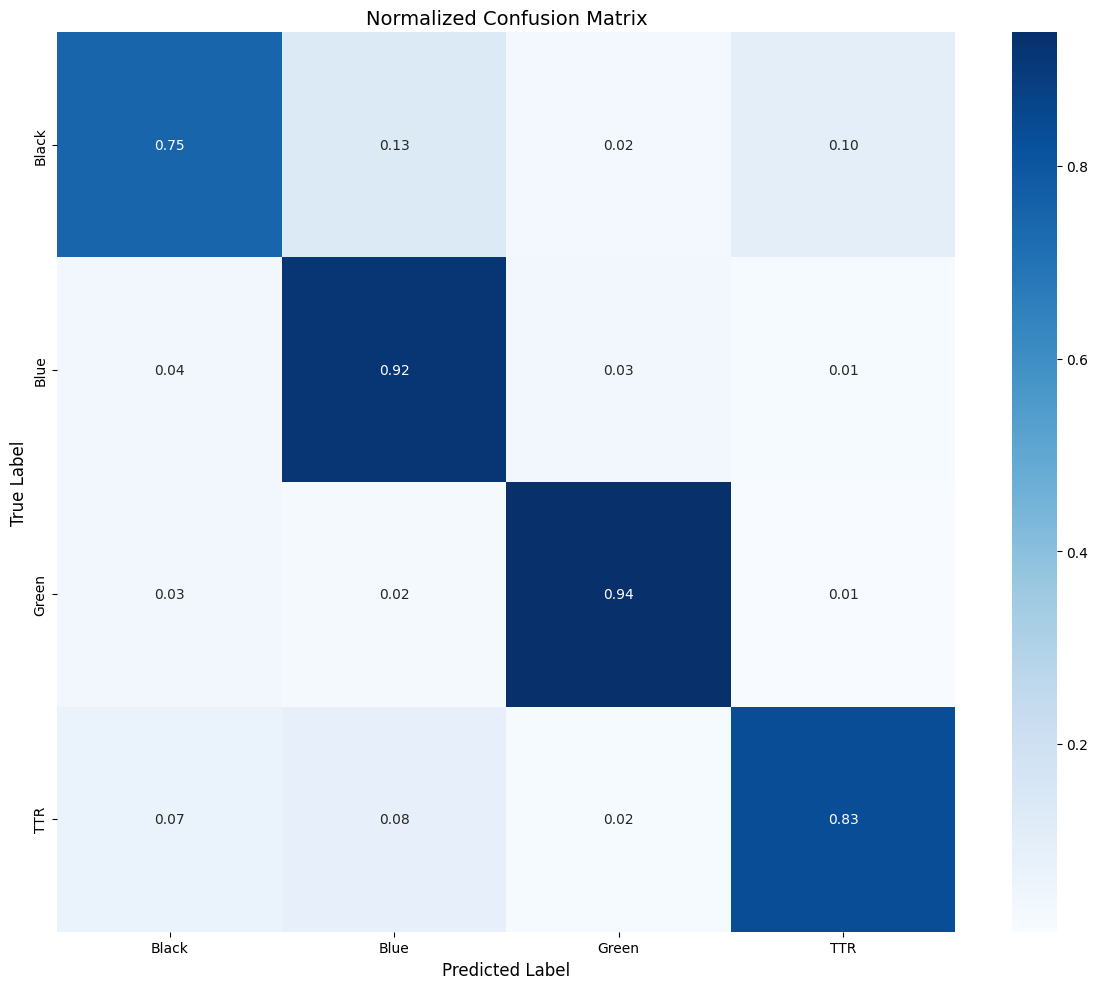

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pathlib
from tqdm import tqdm
import pandas as pd

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics using sklearn
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report with precision, recall, f1-score
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=test_dataset.image_dataset.classes
))

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_dataset.image_dataset.classes,
    yticklabels=test_dataset.image_dataset.classes
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=test_dataset.image_dataset.classes,
    yticklabels=test_dataset.image_dataset.classes
)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.savefig('normalized_confusion_matrix.png', dpi=300)
plt.show()